<a href="https://www.kaggle.com/code/dalloliogm/submission-ensemble?scriptVersionId=240055885" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Ensemble 

This notebook ensembles the best submissions from public notebooks. These have been manually downloaded and upldoade in the elucidata-submissions dataset.

Enjoy and good luck!

In [1]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.stats import spearmanr

def ensemble_submissions(
    submission_folder,
    use_rank=False,
    rank_axis="columns",
    output_prefix=""
):
    assert rank_axis in {"columns", "rows"}, "rank_axis must be 'columns' or 'rows'"

    pattern = re.compile(r"submission_(\d+)\.csv")
    predictions = []
    weights = []
    submission_names = []

    for fname in os.listdir(submission_folder):
        match = pattern.match(fname)
        if not match:
            continue
        score_str = match.group(1)
        score = float("0." + score_str.lstrip("0"))
        df = pd.read_csv(os.path.join(submission_folder, fname))
        pred_cols = [col for col in df.columns if col != "ID"]
        pred = df[pred_cols].copy()

        if use_rank:
            axis = 0 if rank_axis == "columns" else 1
            pred = pred.rank(axis=axis, method="average")

        predictions.append(pred)
        weights.append(score)
        submission_names.append(fname)

    pred_array = np.stack([df.values for df in predictions], axis=-1)  # (N, C, M)
    weights = np.array(weights)
    weights = weights / weights.sum()
    n_samples, n_targets, n_models = pred_array.shape
    ID = df["ID"]
    columns = predictions[0].columns

    rank_suffix = f"_ranked_{rank_axis}" if use_rank else "_raw"

    def save(df_values, name):
        df_out = pd.DataFrame(df_values, columns=columns)
        df_out.insert(0, "ID", ID)
        filename = f"{output_prefix}{name}{rank_suffix}.csv"
        df_out.to_csv(filename, index=False)

    # 1. Power Weighted Average
    power = 3
    w_pow = weights**power
    w_pow /= w_pow.sum()
    ensemble_power = np.average(pred_array, axis=-1, weights=w_pow)
    save(ensemble_power, "ensemble_power_weighted")

    # 2. Top-k Averaging
    k = 3
    top_k_idx = np.argsort(weights)[-k:]
    top_k_preds = pred_array[:, :, top_k_idx]
    top_k_weights = weights[top_k_idx]
    top_k_weights = top_k_weights / top_k_weights.sum()
    ensemble_top_k = np.average(top_k_preds, axis=-1, weights=top_k_weights)
    save(ensemble_top_k, "ensemble_top_k")

    # 3. Blend Best + Average of Others
    best_idx = np.argmax(weights)
    best_model = pred_array[:, :, best_idx]
    others = np.delete(pred_array, best_idx, axis=2)
    others_avg = np.mean(others, axis=2)
    alpha = 0.8
    ensemble_blend = alpha * best_model + (1 - alpha) * others_avg
    save(ensemble_blend, "ensemble_blend_best_avg")

    # 4. Threshold-Based Ensemble
    threshold = 0.3
    mask = weights >= threshold
    if mask.sum() > 0:
        selected_preds = pred_array[:, :, mask]
        selected_weights = weights[mask] / weights[mask].sum()
        ensemble_thresh = np.average(selected_preds, axis=-1, weights=selected_weights)
        save(ensemble_thresh, "ensemble_threshold_0.3")

    # 5. Residual-Based Per-Feature Weighting
    baseline = ensemble_power.copy()
    errors = np.zeros((n_targets, n_models))
    for i in range(n_models):
        pred_i = pred_array[:, :, i]
        errors[:, i] = ((pred_i - baseline) ** 2).mean(axis=0)
    weights_per_target = 1 / (errors + 1e-6)
    weights_per_target /= weights_per_target.sum(axis=1, keepdims=True)
    ensemble_residual = np.einsum("ncm,cm->nc", pred_array, weights_per_target)
    save(ensemble_residual, "ensemble_residual_weighted")

    # 6. Stacking with Ridge Regression
    X_all = np.transpose(pred_array, (0, 2, 1))  # (N, M, C)
    final_preds = np.zeros((n_samples, n_targets))
    y_meta = ensemble_power.copy()
    for i in range(n_targets):
        X_meta = X_all[:, :, i]
        y_target = y_meta[:, i]
        model = Ridge()
        model.fit(X_meta, y_target)
        final_preds[:, i] = model.predict(X_meta)
    save(final_preds, "ensemble_stacking")

    # 7. Greedy Ensemble (maximize Spearman vs power ensemble)
    def average_models(indices):
        return np.mean(pred_array[:, :, indices], axis=-1)

    base = [np.argmax(weights)]
    best = average_models(base)
    for i in range(n_models):
        if i in base:
            continue
        candidate = average_models(base + [i])
        score_best = np.mean([spearmanr(best[:, j], y_meta[:, j])[0] for j in range(n_targets)])
        score_candidate = np.mean([spearmanr(candidate[:, j], y_meta[:, j])[0] for j in range(n_targets)])
        if score_candidate > score_best:
            base.append(i)
            best = candidate
    save(best, "ensemble_greedy")

    # 8. Correlation-Weighted Ensemble (Spearman corr to power baseline)
    corr_weights = []
    for i in range(n_models):
        r = np.mean([spearmanr(pred_array[:, j, i], y_meta[:, j])[0] for j in range(n_targets)])
        corr_weights.append(max(0, r))  # avoid negative weights
    corr_weights = np.array(corr_weights)
    if corr_weights.sum() > 0:
        corr_weights = corr_weights / corr_weights.sum()
        ensemble_corr = np.average(pred_array, axis=-1, weights=corr_weights)
        save(ensemble_corr, "ensemble_correlation_weighted")

    # Save diagnostics
    pd.DataFrame(errors, index=columns, columns=submission_names).to_csv(f"{output_prefix}model_target_errors{rank_suffix}.csv")
    pd.DataFrame(weights_per_target, index=columns, columns=submission_names).to_csv(f"{output_prefix}residual_weights{rank_suffix}.csv")

    print("✅ Ensembles saved using " + ("ranked " if use_rank else "raw ") + f"predictions (axis={rank_axis})")


In [2]:
# Raw value ensembling
ensemble_submissions("/kaggle/input/elucidata-submissions", use_rank=False)



✅ Ensembles saved using raw predictions (axis=columns)


In [3]:
# Rank-based ensembling across columns (C1 to C36)
ensemble_submissions("/kaggle/input/elucidata-submissions", use_rank=True, rank_axis="columns")



✅ Ensembles saved using ranked predictions (axis=columns)


In [4]:
# Rank-based ensembling across rows (per sample)
ensemble_submissions("/kaggle/input/elucidata-submissions", use_rank=True, rank_axis="rows")


✅ Ensembles saved using ranked predictions (axis=rows)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_ensemble_diagnostics(errors_csv, weights_csv):
    """
    Generate heatmap visualizations from ensemble diagnostics.

    Args:
        errors_csv (str): Path to 'model_target_errors*.csv'.
        weights_csv (str): Path to 'residual_weights*.csv'.
    """
    # Load diagnostic CSVs
    errors_df = pd.read_csv(errors_csv, index_col=0)
    weights_df = pd.read_csv(weights_csv, index_col=0)

    # Heatmap: Model-Target Residual Errors (MSE)
    plt.figure(figsize=(14, 6))
    sns.heatmap(errors_df, cmap="Reds", cbar_kws={'label': 'MSE'})
    plt.title("Model-Target Errors (MSE vs Power-Weighted Ensemble)")
    plt.xlabel("Submission")
    plt.ylabel("Target Variable")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Heatmap: Residual-Based Feature Weights
    plt.figure(figsize=(14, 6))
    sns.heatmap(weights_df, cmap="Blues", cbar_kws={'label': 'Normalized Weight'})
    plt.title("Residual-Based Per-Target Model Weights")
    plt.xlabel("Submission")
    plt.ylabel("Target Variable")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

    # Barplot: Average Model Weight (residual-weighted)
    avg_weights = weights_df.mean(axis=0).sort_values(ascending=False)
    plt.figure(figsize=(12, 4))
    sns.barplot(x=avg_weights.index, y=avg_weights.values, palette="coolwarm")
    plt.title("Average Model Weight Across Targets (Residual-Based)")
    plt.ylabel("Mean Weight")
    plt.xlabel("Submission")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


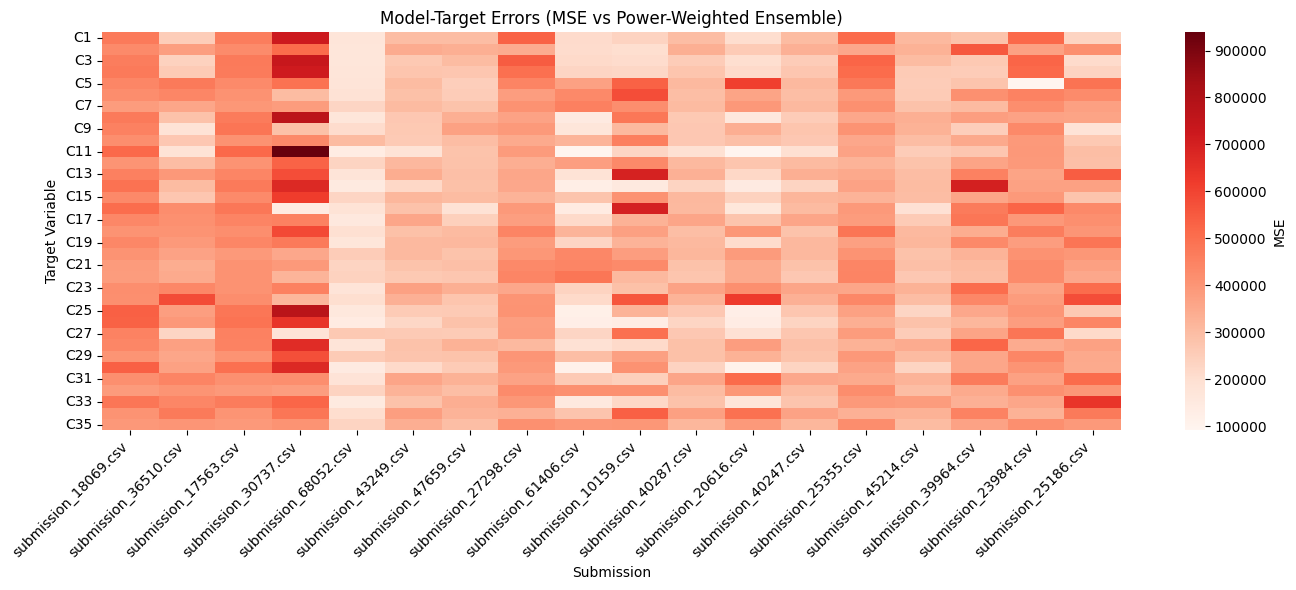

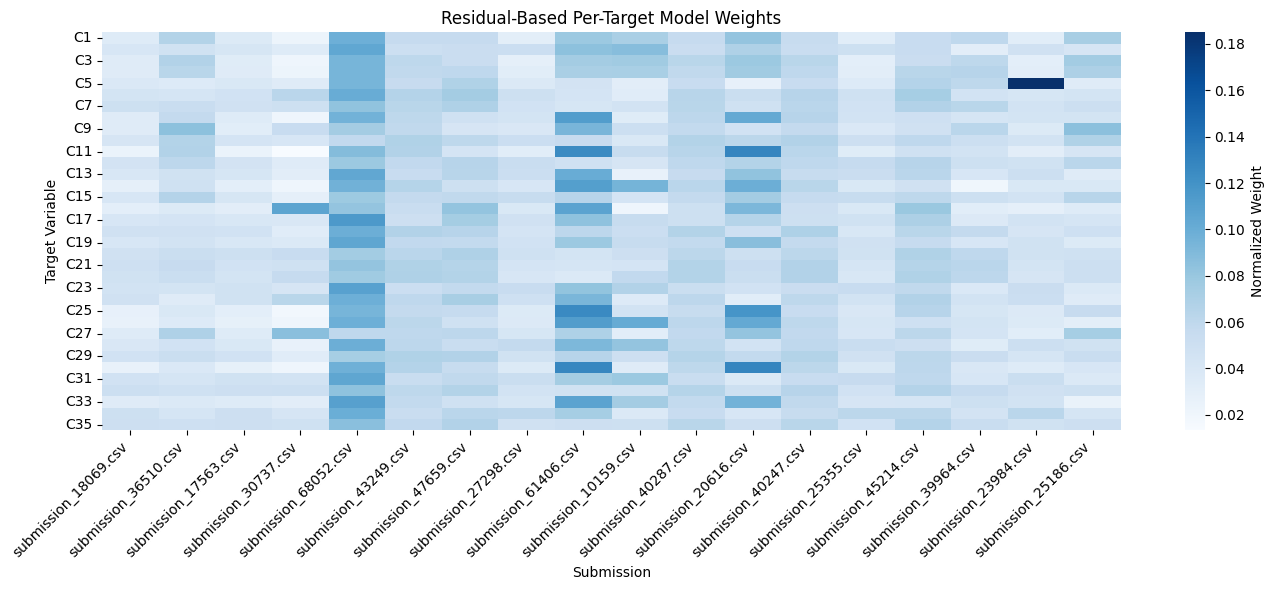

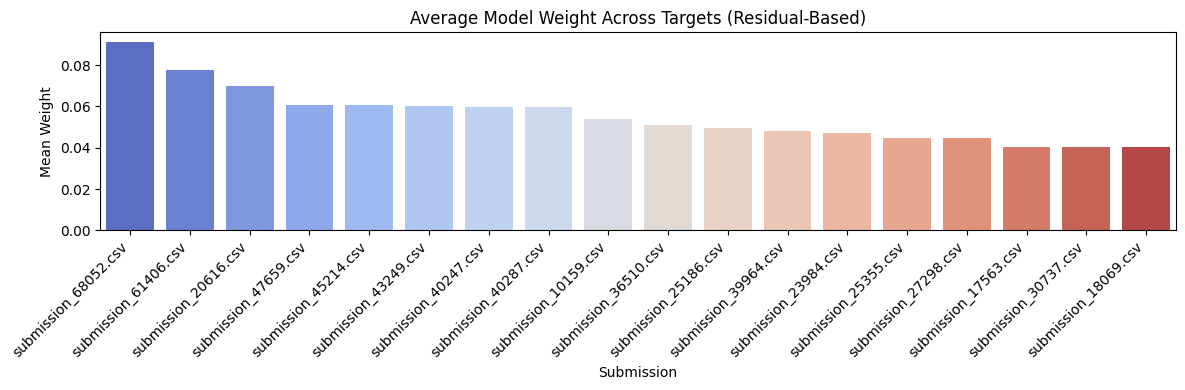

In [6]:
visualize_ensemble_diagnostics(
    errors_csv="model_target_errors_ranked_columns.csv",
    weights_csv="residual_weights_ranked_columns.csv"
)


In [7]:
!ls


ensemble_blend_best_avg_ranked_columns.csv
ensemble_blend_best_avg_ranked_rows.csv
ensemble_blend_best_avg_raw.csv
ensemble_correlation_weighted_ranked_columns.csv
ensemble_correlation_weighted_ranked_rows.csv
ensemble_correlation_weighted_raw.csv
ensemble_greedy_ranked_columns.csv
ensemble_greedy_ranked_rows.csv
ensemble_greedy_raw.csv
ensemble_power_weighted_ranked_columns.csv
ensemble_power_weighted_ranked_rows.csv
ensemble_power_weighted_raw.csv
ensemble_residual_weighted_ranked_columns.csv
ensemble_residual_weighted_ranked_rows.csv
ensemble_residual_weighted_raw.csv
ensemble_stacking_ranked_columns.csv
ensemble_stacking_ranked_rows.csv
ensemble_stacking_raw.csv
ensemble_top_k_ranked_columns.csv
ensemble_top_k_ranked_rows.csv
ensemble_top_k_raw.csv
model_target_errors_ranked_columns.csv
model_target_errors_ranked_rows.csv
model_target_errors_raw.csv
__notebook__.ipynb
residual_weights_ranked_columns.csv
residual_weights_ranked_rows.csv
residual_weights_raw.csv


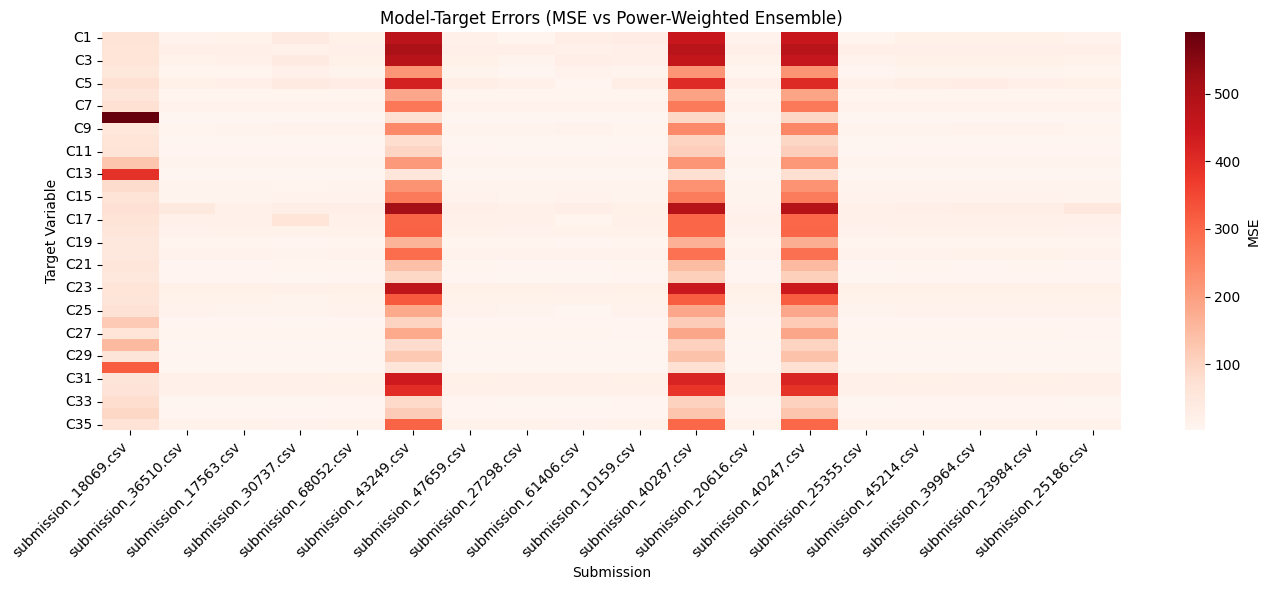

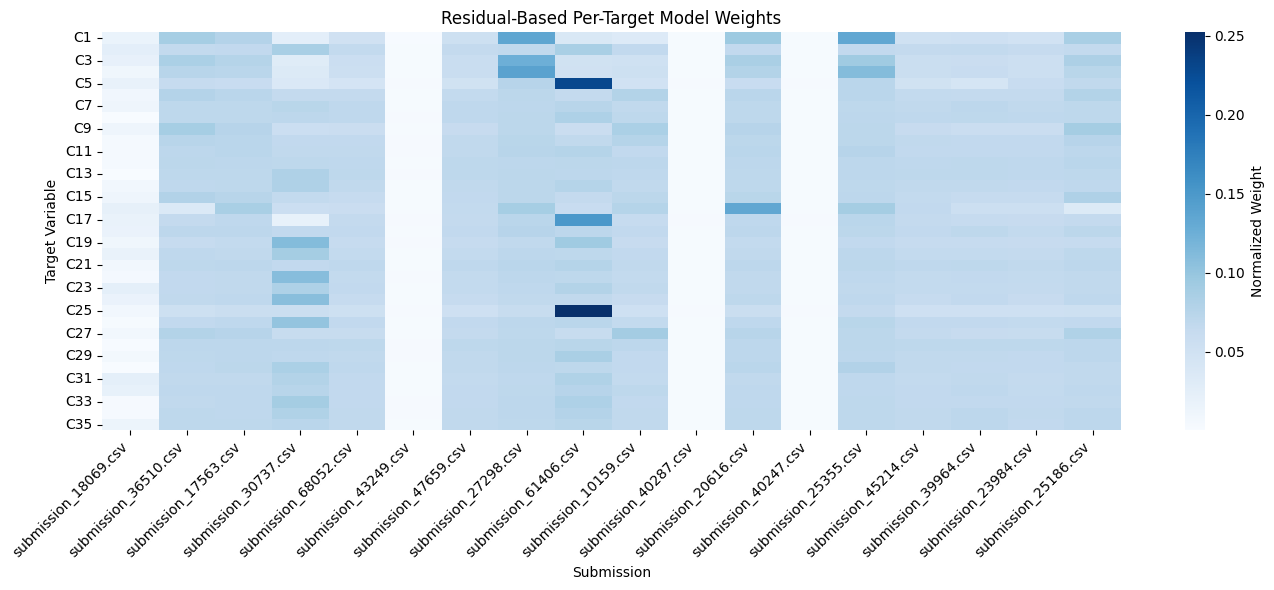

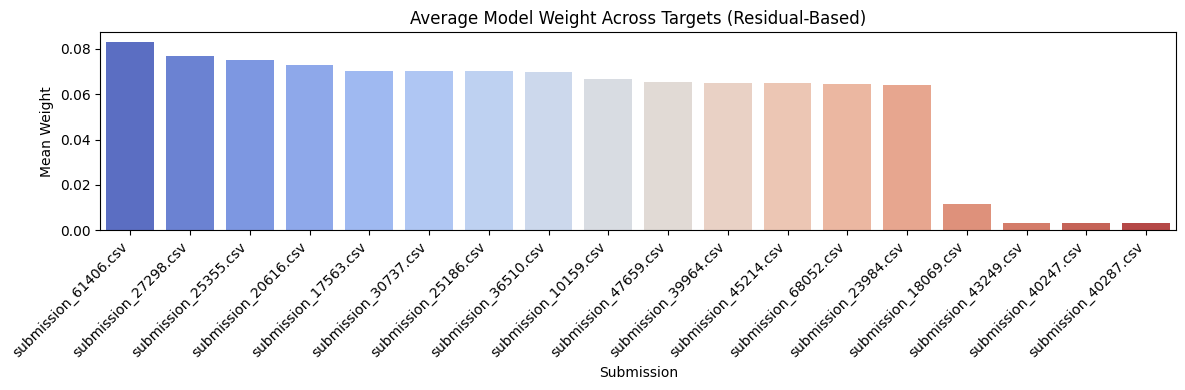

In [8]:
visualize_ensemble_diagnostics(
    errors_csv="model_target_errors_raw.csv",
    weights_csv="residual_weights_raw.csv"
)

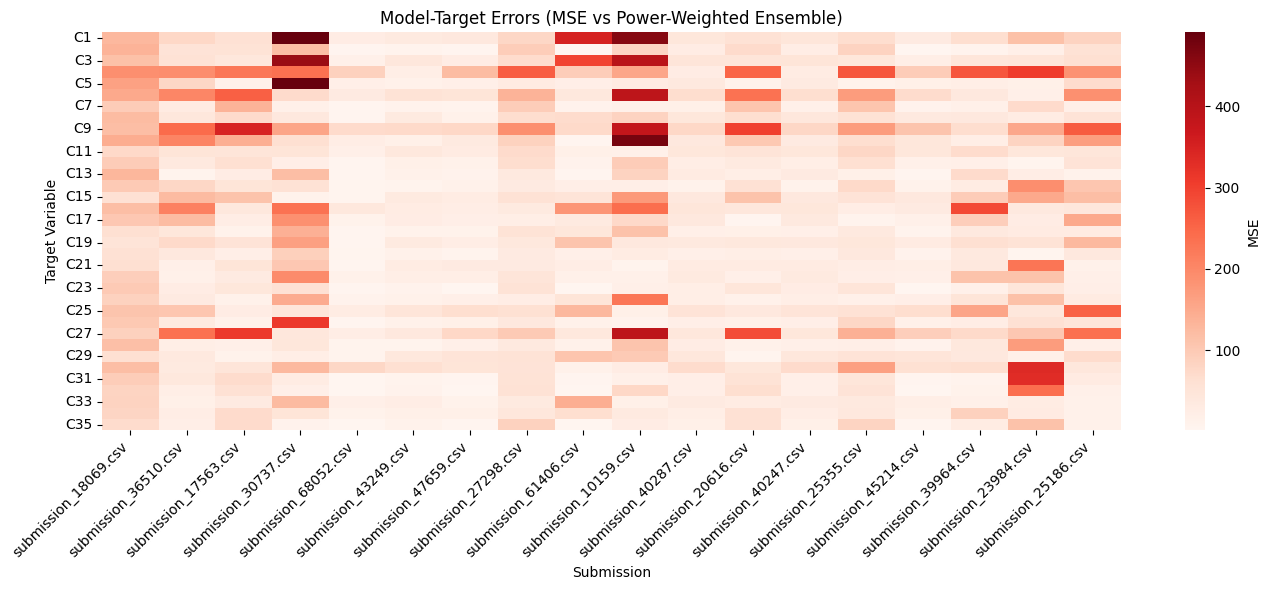

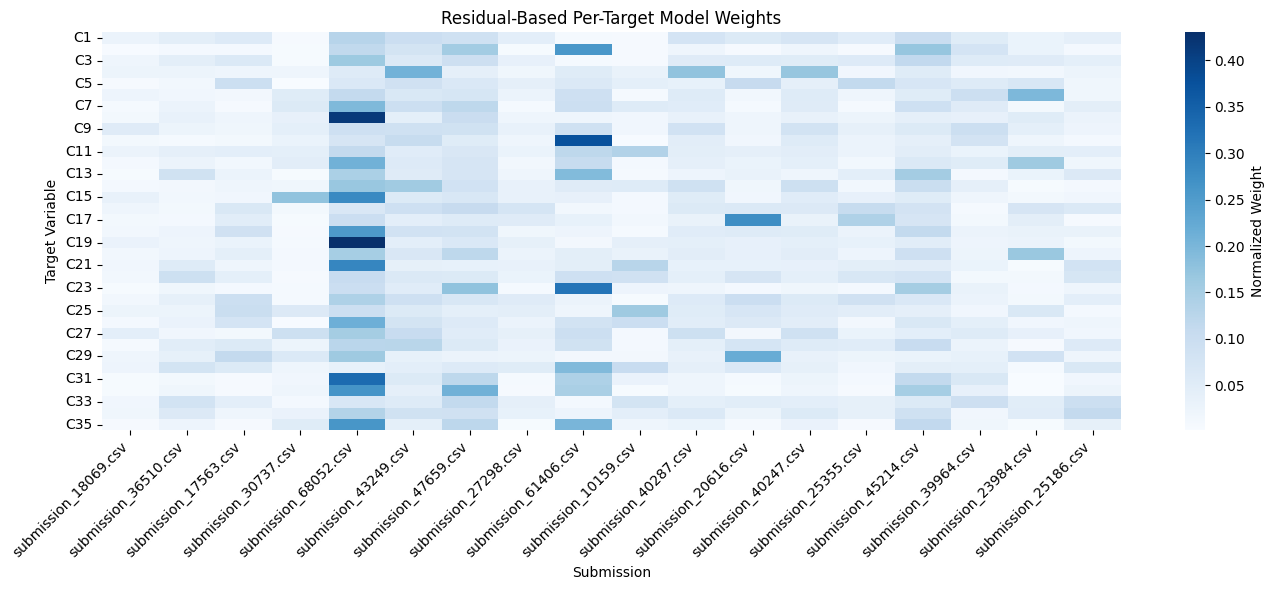

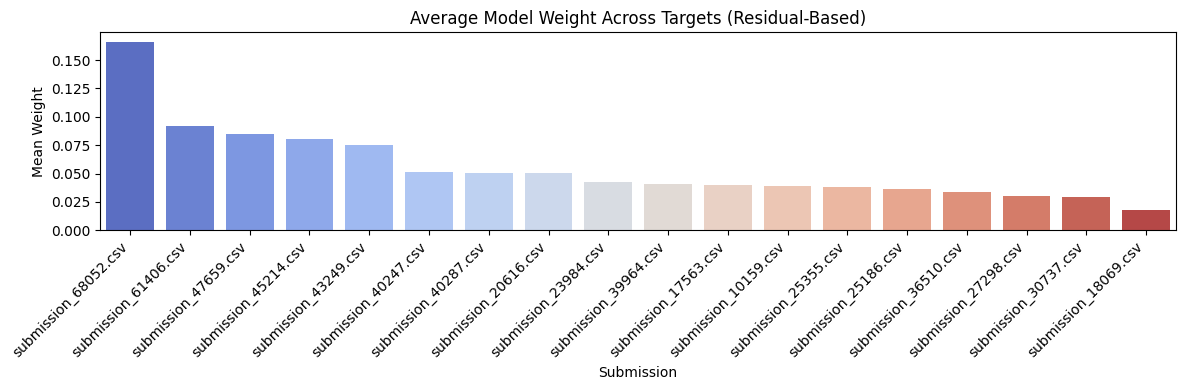

In [9]:
visualize_ensemble_diagnostics(
    errors_csv="model_target_errors_ranked_rows.csv",
    weights_csv="residual_weights_ranked_rows.csv"
)

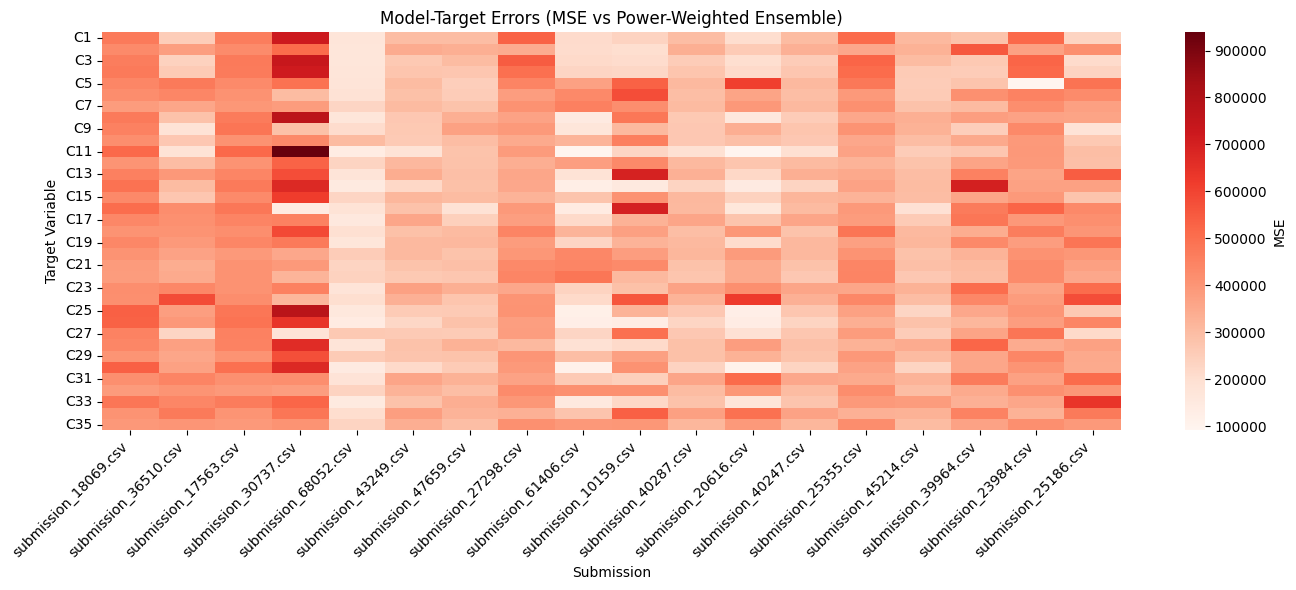

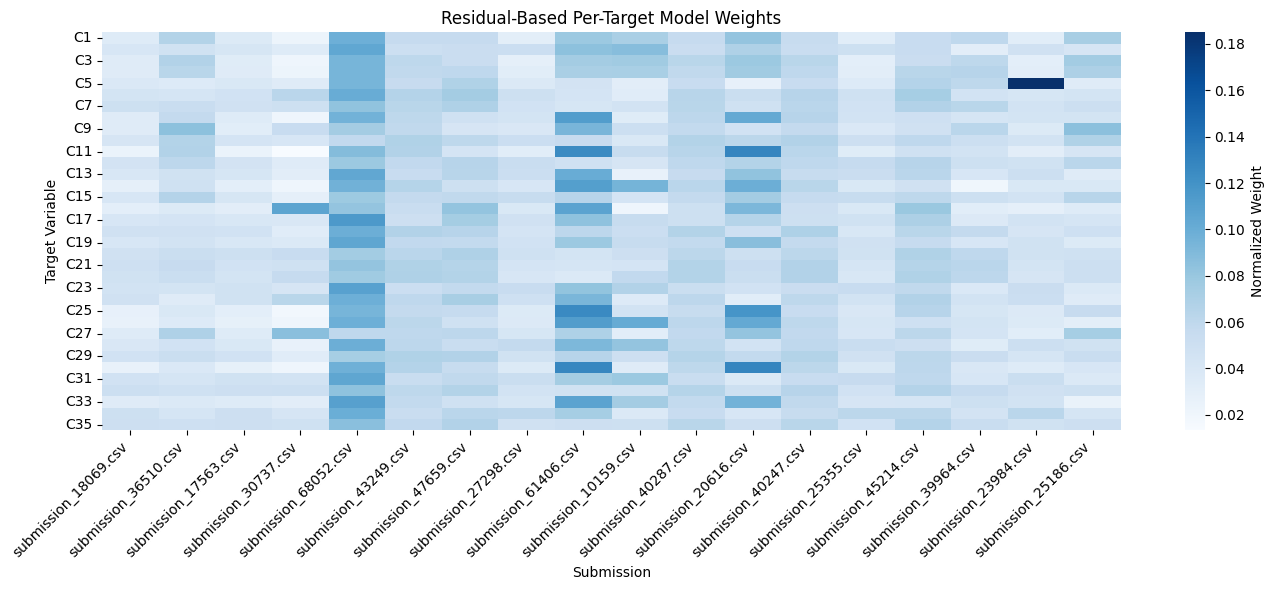

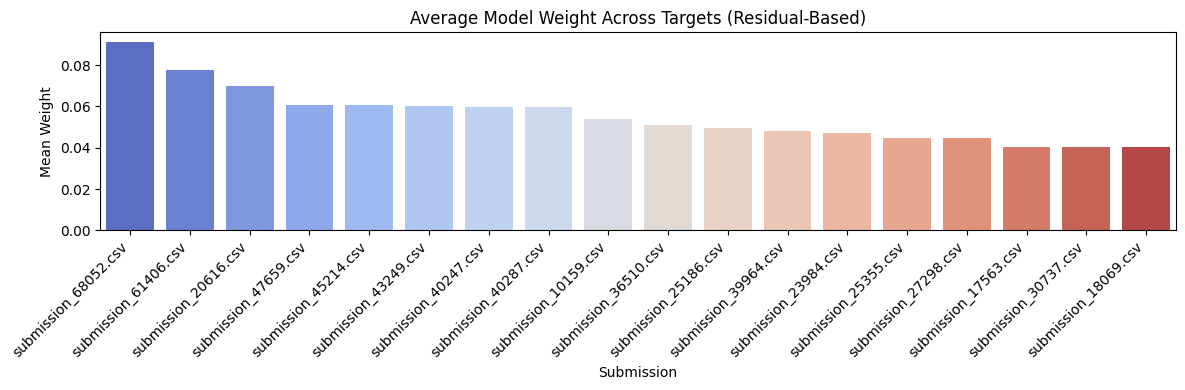

In [10]:
visualize_ensemble_diagnostics(
    errors_csv="model_target_errors_ranked_columns.csv",
    weights_csv="residual_weights_ranked_columns.csv"
)

In [11]:
#visualize_ensemble_diagnostics(
#    errors_csv="model_target_errors.csv",
#    weights_csv="residual_weights.csv"
#)